In [ ]:
import findspark

In [36]:
findspark.init('/home/shaurya/spark-2.4.3-bin-hadoop2.7')

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark Analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
one = spark.read.csv("500_Cities__Local_Data_for_Better_Health__2019_release.csv",header='true')

# Dataset Description

### We got the data from the HealthData government site. It contains exhaustive information relating to health measure across 500 cities in the US. The data is about 27 measures of chronic disease related to unhealthy behaviors (5), health outcomes (13), and use of preventive services (9). The population was gathered using census data from census tracts which measured over regions in any particular city or the city as a whole, state as a whole, or the US as a whole. 

### Dataset found on https://www.cdc.gov/500cities/

In [3]:
one.show(1)

+----+---------+---------+--------+---------------+----------+----------+-------------------+--------------------+---------------+---------------+----------------+----------+--------------------+---------------------+--------------------------+-------------------+---------------+--------------------+----------+---------+--------+-----------+-------------------+
|Year|StateAbbr|StateDesc|CityName|GeographicLevel|DataSource|  Category|           UniqueID|             Measure|Data_Value_Unit|DataValueTypeID| Data_Value_Type|Data_Value|Low_Confidence_Limit|High_Confidence_Limit|Data_Value_Footnote_Symbol|Data_Value_Footnote|PopulationCount|         GeoLocation|CategoryID|MeasureId|CityFIPS|  TractFIPS|Short_Question_Text|
+----+---------+---------+--------+---------------+----------+----------+-------------------+--------------------+---------------+---------------+----------------+----------+--------------------+---------------------+--------------------------+-------------------+--------

In [4]:
one.limit(2).toPandas()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,...,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2017,GA,Georgia,Savannah,Census Tract,BRFSS,Prevention,1369000-13051004002,Visits to doctor for routine checkup within th...,%,...,75.5,None,None,3697,"(32.0005963715, -81.1016216322)",PREVENT,CHECKUP,1369000,13051004002,Annual Checkup
1,2017,HI,Hawaii,Honolulu,Census Tract,BRFSS,Health Outcomes,15003003101,Coronary heart disease among adults aged >=18 ...,%,...,5.6,None,None,3687,"(21.3258064243, -157.793873751)",HLTHOUT,CHD,15003,15003003101,Coronary Heart Disease


In [5]:
one.printSchema()

root
 |-- Year: string (nullable = true)
 |-- StateAbbr: string (nullable = true)
 |-- StateDesc: string (nullable = true)
 |-- CityName: string (nullable = true)
 |-- GeographicLevel: string (nullable = true)
 |-- DataSource: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- UniqueID: string (nullable = true)
 |-- Measure: string (nullable = true)
 |-- Data_Value_Unit: string (nullable = true)
 |-- DataValueTypeID: string (nullable = true)
 |-- Data_Value_Type: string (nullable = true)
 |-- Data_Value: string (nullable = true)
 |-- Low_Confidence_Limit: string (nullable = true)
 |-- High_Confidence_Limit: string (nullable = true)
 |-- Data_Value_Footnote_Symbol: string (nullable = true)
 |-- Data_Value_Footnote: string (nullable = true)
 |-- PopulationCount: string (nullable = true)
 |-- GeoLocation: string (nullable = true)
 |-- CategoryID: string (nullable = true)
 |-- MeasureId: string (nullable = true)
 |-- CityFIPS: string (nullable = true)
 |-- TractFIPS: str

# Data Preparation

### (1.) Changing the columns datatypes

In [6]:
from pyspark.sql.functions import col , column
one=one.withColumn("PopulationCount",one["PopulationCount"].cast("bigint"))
one=one.withColumn("Data_Value",one["Data_Value"].cast("float"))
one=one.withColumn("Low_Confidence_Limit",one["Low_Confidence_Limit"].cast("float"))
one=one.withColumn("High_Confidence_Limit",one["High_Confidence_Limit"].cast("float"))

In [7]:
one.printSchema()

root
 |-- Year: string (nullable = true)
 |-- StateAbbr: string (nullable = true)
 |-- StateDesc: string (nullable = true)
 |-- CityName: string (nullable = true)
 |-- GeographicLevel: string (nullable = true)
 |-- DataSource: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- UniqueID: string (nullable = true)
 |-- Measure: string (nullable = true)
 |-- Data_Value_Unit: string (nullable = true)
 |-- DataValueTypeID: string (nullable = true)
 |-- Data_Value_Type: string (nullable = true)
 |-- Data_Value: float (nullable = true)
 |-- Low_Confidence_Limit: float (nullable = true)
 |-- High_Confidence_Limit: float (nullable = true)
 |-- Data_Value_Footnote_Symbol: string (nullable = true)
 |-- Data_Value_Footnote: string (nullable = true)
 |-- PopulationCount: long (nullable = true)
 |-- GeoLocation: string (nullable = true)
 |-- CategoryID: string (nullable = true)
 |-- MeasureId: string (nullable = true)
 |-- CityFIPS: string (nullable = true)
 |-- TractFIPS: string (

In [8]:
print((one.count(), len(one.columns)))

(810103, 24)


In [9]:
import pandas as pd

### (2.) Checking null values and the NAN values in the dataset

In [10]:
from pyspark.sql.functions import isnan, when, count, col, isnull

# Checking NAN values in the dataset --> None 
one.select([count(when(isnan(c), c)).alias(c) for c in one.columns]).show()

+----+---------+---------+--------+---------------+----------+--------+--------+-------+---------------+---------------+---------------+----------+--------------------+---------------------+--------------------------+-------------------+---------------+-----------+----------+---------+--------+---------+-------------------+
|Year|StateAbbr|StateDesc|CityName|GeographicLevel|DataSource|Category|UniqueID|Measure|Data_Value_Unit|DataValueTypeID|Data_Value_Type|Data_Value|Low_Confidence_Limit|High_Confidence_Limit|Data_Value_Footnote_Symbol|Data_Value_Footnote|PopulationCount|GeoLocation|CategoryID|MeasureId|CityFIPS|TractFIPS|Short_Question_Text|
+----+---------+---------+--------+---------------+----------+--------+--------+-------+---------------+---------------+---------------+----------+--------------------+---------------------+--------------------------+-------------------+---------------+-----------+----------+---------+--------+---------+-------------------+
|   0|        0|      

In [11]:
# Checking NULL values in the dataset --> None 
one.select([count(when(isnull(c), c)).alias(c) for c in one.columns]).toPandas()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,...,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,0,0,0,56,0,0,0,0,0,0,...,22792,787309,787309,0,56,0,0,56,28056,0


#### Saving original 'one' dataframe in two

In [13]:
two = one

### (3.) Dropping columns and rows which are not required for our analysis and have null values.

#### Dropping columns 'Data_Value_Footnote',  'Data_Value_Footnote_Symbol',  'TractFIPS',  'CityFIPS',  'Geolocation' 

#### And dropping all rows with null values

In [14]:
columns_to_drop = ['Data_Value_Footnote', 'Data_Value_Footnote_Symbol', 'TractFIPS', 'CityFIPS', 'GeoLocation']
two = two.drop(*columns_to_drop)

two = two.na.drop()

# no data value for the tracts with population less than 50
#two = two.where(col("Data_Value").isNotNull())

In [15]:
two.select([count(when(isnull(c), c)).alias(c) for c in two.columns]).toPandas()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,CategoryID,MeasureId,Short_Question_Text
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Data Exploration

In [16]:
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

two.createOrReplaceTempView("Viewone")
res1 = spark.sql("select * from Viewone")

res1.limit(2).toPandas()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,CategoryID,MeasureId,Short_Question_Text
0,2017,GA,Georgia,Savannah,Census Tract,BRFSS,Prevention,1369000-13051004002,Visits to doctor for routine checkup within th...,%,CrdPrv,Crude prevalence,74.800003,74.0,75.5,3697,PREVENT,CHECKUP,Annual Checkup
1,2017,HI,Hawaii,Honolulu,Census Tract,BRFSS,Health Outcomes,15003003101,Coronary heart disease among adults aged >=18 ...,%,CrdPrv,Crude prevalence,4.900000,4.4,5.6,3687,HLTHOUT,CHD,Coronary Heart Disease


In [17]:
res4 = spark.sql("select distinct Category from Viewone")
res4.show()

+-------------------+
|           Category|
+-------------------+
|Unhealthy Behaviors|
|         Prevention|
|    Health Outcomes|
+-------------------+



#### Unhealthy Behavior measures

In [18]:
res5 = spark.sql("select distinct Measure from Viewone where Category = 'Unhealthy Behaviors'")
pd.set_option('display.max_colwidth',200)
res5.limit(10).toPandas()

,Measure
0,Current smoking among adults aged >=18 Years
1,Binge drinking among adults aged >=18 Years
2,Sleeping less than 7 hours among adults aged >=18 Years
3,No leisure-time physical activity among adults aged >=18 Years
4,Obesity among adults aged >=18 Years


#### Prevention measures

In [19]:
res6 = spark.sql("select distinct Measure from Viewone where Category = 'Prevention'")
res6.limit(110).toPandas()

,Measure
0,"Older adult women aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 Years"
1,Papanicolaou smear use among adult women aged 21–65 Years
2,Visits to doctor for routine checkup within the past Year among adults aged >=18 Years
3,Mammography use among women aged 50–74 Years
4,Current lack of health insurance among adults aged 18–64 Years
5,"Older adult men aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening"
6,Cholesterol screening among adults aged >=18 Years
7,Taking medicine for high blood pressure control among adults aged >=18 Years with high blood pressure
8,Visits to dentist or dental clinic among adults aged >=18 Years
9,"Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50–75 Years"


#### Health Outcomes measures

In [20]:
res7 = spark.sql("select distinct Measure from Viewone where Category = 'Health Outcomes'")
res7.limit(110).toPandas()

,Measure
0,Cancer (excluding skin cancer) among adults aged >=18 Years
1,Arthritis among adults aged >=18 Years
2,Current asthma among adults aged >=18 Years
3,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years
4,Coronary heart disease among adults aged >=18 Years
5,Mental health not good for >=14 days among adults aged >=18 Years
6,Chronic obstructive pulmonary disease among adults aged >=18 Years
7,Chronic kidney disease among adults aged >=18 Years
8,High blood pressure among adults aged >=18 Years
9,Diagnosed diabetes among adults aged >=18 Years


In [21]:
resWA = spark.sql("select Year,StateAbbr,StateDesc,CityName,GeographicLevel,Category,\
                 Measure,Data_Value,PopulationCount,CategoryID,MeasureId,Short_Question_Text \
                 from Viewone where Year = '2017'  and DataValueTypeID = 'CrdPrv' and StateAbbr='WA' ")
resWA.limit(1).toPandas()

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,Category,Measure,Data_Value,PopulationCount,CategoryID,MeasureId,Short_Question_Text
0,2017,WA,Washington,Auburn,City,Health Outcomes,Coronary heart disease among adults aged >=18 Years,5.1,70180,HLTHOUT,CHD,Coronary Heart Disease


In [22]:
resWA.createOrReplaceTempView("WA")

# Washington 

In [23]:
WA2= spark.sql("select distinct CityName from WA ")
WA2.limit(20).toPandas()

,CityName
0,Auburn
1,Everett
2,Bellingham
3,Spokane Valley
4,Yakima
5,Vancouver
6,Seattle
7,Kent
8,Kennewick
9,Spokane


#  What are the cities that have the highest and lowest heart-related issues?

In [24]:
WA8= spark.sql("select CityName, Measure, Data_Value from WA where \
    Measure = 'Stroke among adults aged >=18 Years'and GeographicLevel = 'City' order by Data_Value desc ")
data1 = WA8.limit(20).toPandas()
data1

,CityName,Measure,Data_Value
0,Yakima,Stroke among adults aged >=18 Years,3.7
1,Spokane,Stroke among adults aged >=18 Years,3.2
2,Spokane Valley,Stroke among adults aged >=18 Years,3.2
3,Kennewick,Stroke among adults aged >=18 Years,3.1
4,Vancouver,Stroke among adults aged >=18 Years,3.0
5,Tacoma,Stroke among adults aged >=18 Years,3.0
6,Kent,Stroke among adults aged >=18 Years,2.9
7,Auburn,Stroke among adults aged >=18 Years,2.9
8,Federal Way,Stroke among adults aged >=18 Years,2.9
9,Everett,Stroke among adults aged >=18 Years,2.8


In [25]:
import matplotlib 
from matplotlib import pyplot as plt
from pandas import DataFrame

In [26]:
WA11= spark.sql("select CityName, Measure, Data_Value from WA where \
    Measure = 'Coronary heart disease among adults aged >=18 Years'and GeographicLevel = 'City' order by Data_Value desc ")

data2 = WA11.limit(20).toPandas()
data2

,CityName,Measure,Data_Value
0,Yakima,Coronary heart disease among adults aged >=18 Years,6.9
1,Spokane Valley,Coronary heart disease among adults aged >=18 Years,6.1
2,Spokane,Coronary heart disease among adults aged >=18 Years,5.9
3,Tacoma,Coronary heart disease among adults aged >=18 Years,5.6
4,Kennewick,Coronary heart disease among adults aged >=18 Years,5.6
5,Vancouver,Coronary heart disease among adults aged >=18 Years,5.6
6,Everett,Coronary heart disease among adults aged >=18 Years,5.1
7,Auburn,Coronary heart disease among adults aged >=18 Years,5.1
8,Federal Way,Coronary heart disease among adults aged >=18 Years,4.9
9,Kent,Coronary heart disease among adults aged >=18 Years,4.8


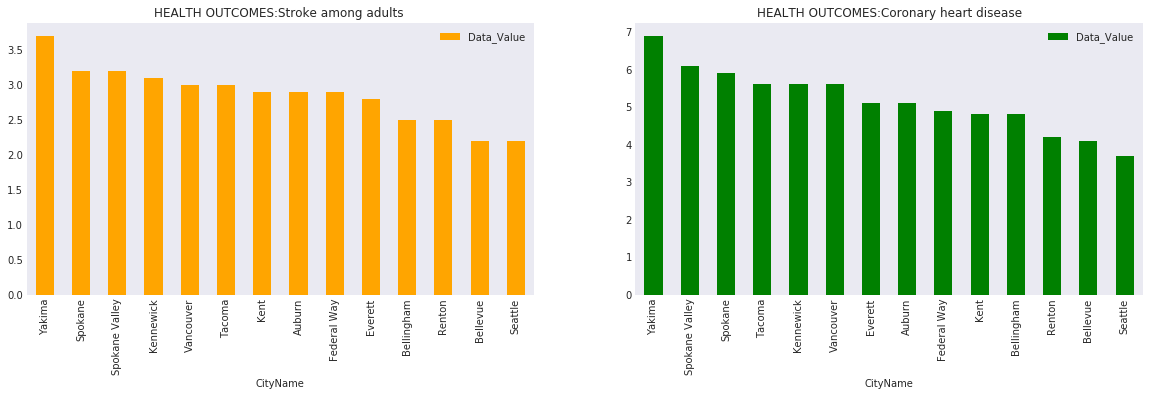

In [28]:
fig1, ax2 = plt.subplots(ncols=2, figsize=(10,5))

data1.plot.bar(title = 'HEALTH OUTCOMES:Stroke among adults ', x ='CityName', y='Data_Value', figsize=(20, 5), color ='orange', ax= ax2[0] )
data2.plot.bar(title = 'HEALTH OUTCOMES:Coronary heart disease', x ='CityName', y='Data_Value', figsize=(20, 5), color ='green', ax= ax2[1] )


In [29]:
WA10= spark.sql("select CityName, Measure, Data_Value from WA where \
    Measure = 'High blood pressure among adults aged >=18 Years'and GeographicLevel = 'City' order by Data_Value desc ")
data3=WA10.limit(100).toPandas()
data3

,CityName,Measure,Data_Value
0,Yakima,High blood pressure among adults aged >=18 Years,32.200001
1,Tacoma,High blood pressure among adults aged >=18 Years,31.500000
2,Everett,High blood pressure among adults aged >=18 Years,29.799999
3,Spokane Valley,High blood pressure among adults aged >=18 Years,29.299999
4,Kennewick,High blood pressure among adults aged >=18 Years,29.000000
5,Vancouver,High blood pressure among adults aged >=18 Years,28.900000
6,Spokane,High blood pressure among adults aged >=18 Years,28.400000
7,Federal Way,High blood pressure among adults aged >=18 Years,26.200001
8,Auburn,High blood pressure among adults aged >=18 Years,26.100000
9,Kent,High blood pressure among adults aged >=18 Years,25.600000


In [30]:
WA100= spark.sql("select CityName, Measure, Data_Value from WA where \
    Measure = 'High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years'and GeographicLevel = 'City' order by Data_Value desc ")
WA100.limit(100).toPandas()
data4 = WA100.limit(100).toPandas()
data4

,CityName,Measure,Data_Value
0,Kennewick,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,33.099998
1,Spokane Valley,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,32.599998
2,Vancouver,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,31.700001
3,Spokane,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,31.600000
4,Yakima,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,31.600000
5,Tacoma,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,31.200001
6,Everett,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,29.900000
7,Auburn,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,29.700001
8,Federal Way,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,29.600000
9,Bellingham,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,28.799999


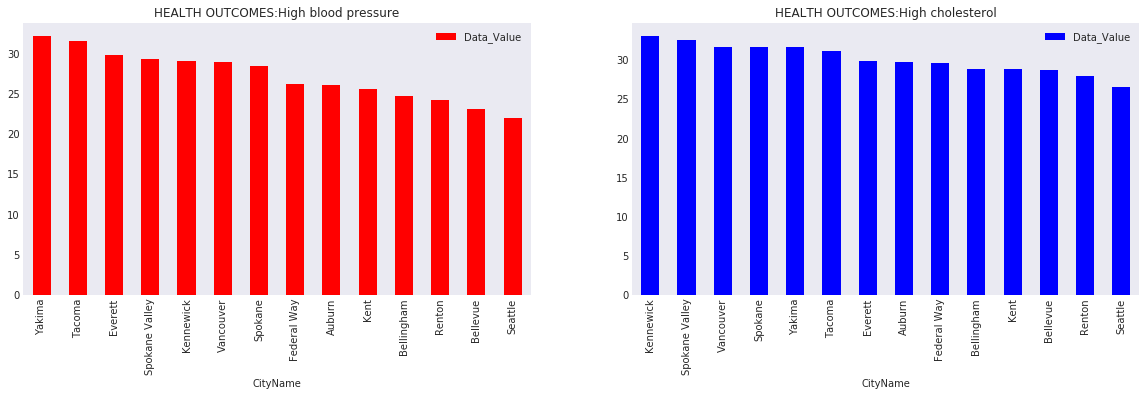

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

#df = pd.DataFrame([[5.1, 3.5, 0], [4.9, 3.0, 0], [7.0, 3.2, 1],
#                [6.4, 3.2, 1], [5.9, 3.0, 2], [7.1, 4.5, 2]],
#                columns=['X', 'Y', 'value'])
data3.plot.bar(title = 'HEALTH OUTCOMES:High blood pressure', x ='CityName', y='Data_Value', figsize=(20, 5), color ='red', ax= ax[0] )
data4.plot.bar(title = 'HEALTH OUTCOMES:High cholesterol', x ='CityName', y='Data_Value', figsize=(20, 5), color ='blue', ax= ax[1])
#df.plot.scatter(x='X', y='Y', c='red', ax=ax[1])

### Answer: We found that Yakima consistently has the highest percentages among all heart-related issues with Seattle and Bellevue having the lowest across all heart-related issues.

# What are the preventative measures in place?

In [33]:
WA60= spark.sql("select CityName,Measure,Data_Value,Category from WA where \
    Measure = 'Cholesterol screening among adults aged >=18 Years' and GeographicLevel ='City' and \
    Category = 'Prevention' and CityName in ('Bellevue','Seattle','Yakima')order by Data_Value \
      desc")
data5=WA60.limit(14).toPandas()
data5

,CityName,Measure,Data_Value,Category
0,Bellevue,Cholesterol screening among adults aged >=18 Years,81.699997,Prevention
1,Seattle,Cholesterol screening among adults aged >=18 Years,78.000000,Prevention
2,Yakima,Cholesterol screening among adults aged >=18 Years,74.099998,Prevention


In [34]:
WA61= spark.sql("select CityName,Measure,Data_Value,Category from WA where \
    Measure = 'Taking medicine for high blood pressure control among adults aged >=18 Years with high blood pressure' and GeographicLevel ='City' and \
    Category = 'Prevention' and CityName in ('Bellevue','Seattle','Yakima')order by Data_Value \
      desc")
data6=WA61.limit(14).toPandas()
data6

,CityName,Measure,Data_Value,Category
0,Yakima,Taking medicine for high blood pressure control among adults aged >=18 Years with high blood pressure,70.199997,Prevention
1,Bellevue,Taking medicine for high blood pressure control among adults aged >=18 Years with high blood pressure,66.000000,Prevention
2,Seattle,Taking medicine for high blood pressure control among adults aged >=18 Years with high blood pressure,62.500000,Prevention


In [36]:
WA62= spark.sql("select CityName,Measure,Data_Value,Category from WA where \
    Measure = 'Visits to doctor for routine checkup within the past Year among adults aged >=18 Years' and GeographicLevel ='City' and \
    Category = 'Prevention' and CityName in ('Bellevue','Seattle','Yakima')order by Data_Value \
      desc")
data7=WA62.limit(14).toPandas()
data7

,CityName,Measure,Data_Value,Category
0,Bellevue,Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,64.400002,Prevention
1,Yakima,Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,62.099998,Prevention
2,Seattle,Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,61.900002,Prevention


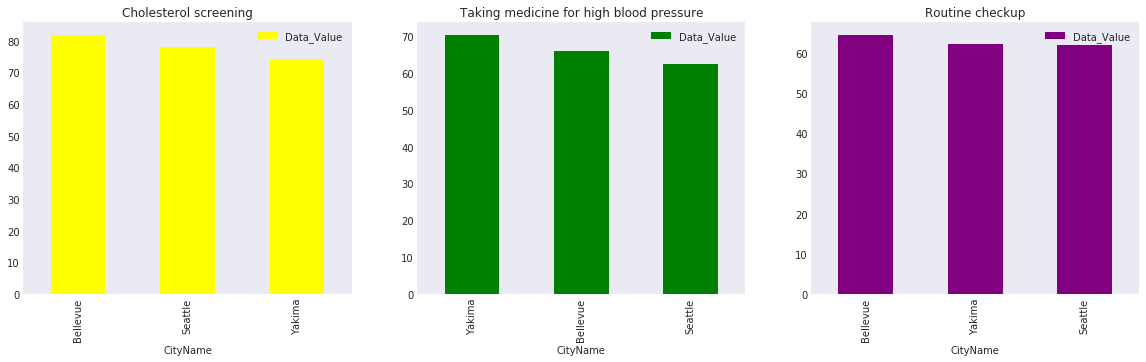

In [38]:
fig1, ax1 = plt.subplots(ncols=3, figsize=(13,10))

#df = pd.DataFrame([[5.1, 3.5, 0], [4.9, 3.0, 0], [7.0, 3.2, 1],
#                [6.4, 3.2, 1], [5.9, 3.0, 2], [7.1, 4.5, 2]],
#                columns=['X', 'Y', 'value'])
data5.plot.bar(title = 'Cholesterol screening', x ='CityName', y='Data_Value', figsize=(20, 5), color ='yellow', ax= ax1[0] )
data6.plot.bar(title = 'Taking medicine for high blood pressure', x ='CityName', y='Data_Value', figsize=(20, 5), color ='green', ax= ax1[1])
data7.plot.bar(title = 'Routine checkup', x ='CityName', y='Data_Value', figsize=(20, 5), color ='purple', ax= ax1[2])
#df.plot.scatter(x='X', y='Y', c='red', ax=ax[1])

### Answer: We found that in all three cities, there is no significant amount of disparity in taking the prevention measures. For example, most of the participants in all three cities were taking blood pressure medication, regularly visiting the doctor, and also getting screened for cholesterol.

# Are there unhealthy behaviors that contribute to these measures for each city?

In [39]:
WA6= spark.sql("select CityName,Measure,Data_Value,Category from WA where \
    Measure = 'Obesity among adults aged >=18 Years' and GeographicLevel ='City' and \
    CityName in ('Bellevue','Seattle','Yakima')order by Data_Value \
      desc")
data8=WA6.limit(14).toPandas()
data8

,CityName,Measure,Data_Value,Category
0,Yakima,Obesity among adults aged >=18 Years,36.799999,Unhealthy Behaviors
1,Seattle,Obesity among adults aged >=18 Years,20.799999,Unhealthy Behaviors
2,Bellevue,Obesity among adults aged >=18 Years,18.000000,Unhealthy Behaviors


In [40]:
WA3= spark.sql("select CityName,Measure,Data_Value,Category from WA where \
    Measure = 'Current smoking among adults aged >=18 Years' and GeographicLevel ='City' and \
    CityName in ('Bellevue','Seattle','Yakima')order by Data_Value \
      desc")
data9=WA3.limit(14).toPandas()
data9

,CityName,Measure,Data_Value,Category
0,Yakima,Current smoking among adults aged >=18 Years,17.9,Unhealthy Behaviors
1,Seattle,Current smoking among adults aged >=18 Years,10.2,Unhealthy Behaviors
2,Bellevue,Current smoking among adults aged >=18 Years,8.4,Unhealthy Behaviors


In [41]:
WA5= spark.sql("select CityName,Measure,Data_Value,Category from WA where \
    Measure = 'No leisure-time physical activity among adults aged >=18 Years' and GeographicLevel ='City' and \
    CityName in ('Bellevue','Seattle','Yakima')order by Data_Value \
      desc")
data10=WA5.limit(14).toPandas()
data10

,CityName,Measure,Data_Value,Category
0,Yakima,No leisure-time physical activity among adults aged >=18 Years,28.5,Unhealthy Behaviors
1,Seattle,No leisure-time physical activity among adults aged >=18 Years,14.3,Unhealthy Behaviors
2,Bellevue,No leisure-time physical activity among adults aged >=18 Years,13.6,Unhealthy Behaviors


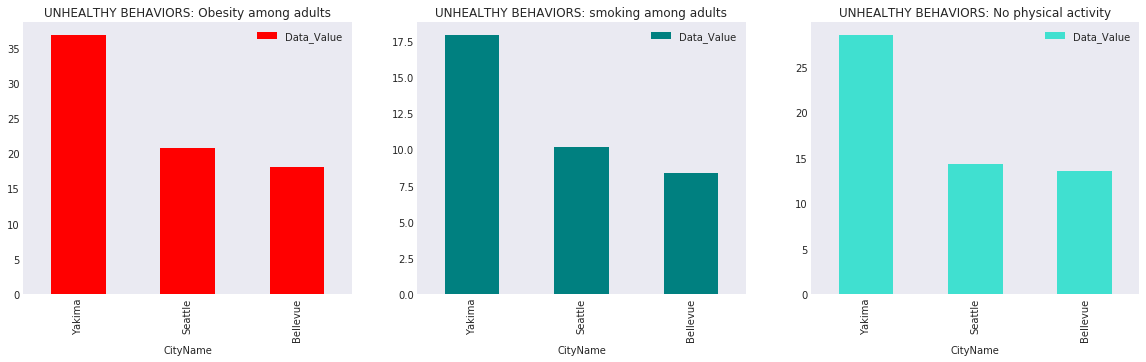

In [43]:
fig3, ax3 = plt.subplots(ncols=3, figsize=(13,10))

#df = pd.DataFrame([[5.1, 3.5, 0], [4.9, 3.0, 0], [7.0, 3.2, 1],
#                [6.4, 3.2, 1], [5.9, 3.0, 2], [7.1, 4.5, 2]],
#                columns=['X', 'Y', 'value'])
data8.plot.bar(title = 'UNHEALTHY BEHAVIORS: Obesity among adults', x ='CityName', y='Data_Value', figsize=(20, 5), color ='red', ax= ax3[0] )
data9.plot.bar(title = 'UNHEALTHY BEHAVIORS: smoking among adults', x ='CityName', y='Data_Value', figsize=(20, 5), color ='teal', ax= ax3[1])
data10.plot.bar(title = 'UNHEALTHY BEHAVIORS: No physical activity', x ='CityName', y='Data_Value', figsize=(20, 5), color ='turquoise', ax= ax3[2])
#df.plot.scatter(x='X', y='Y', c='red', ax=ax[1])

### Answer: As compared to the preventative measures, the unhealthy behaviors show a drastic difference betweent the cities. This means that despite going to the doctor, taking medicine, and cholesterol screening, the residents in Yakima are still largely unhealthier because they indulge in too many unhealthy behaviors.

# Is this based on population? 

In [44]:
WA7= spark.sql("select CityName,PopulationCount from WA where \
    Measure = 'Obesity among adults aged >=18 Years' and GeographicLevel ='City'and \
    CityName in ('Bellevue','Seattle','Yakima') order by PopulationCount \
      desc")
data11=WA7.limit(14).toPandas()
data11

,CityName,PopulationCount
0,Seattle,608660
1,Bellevue,122363
2,Yakima,91067


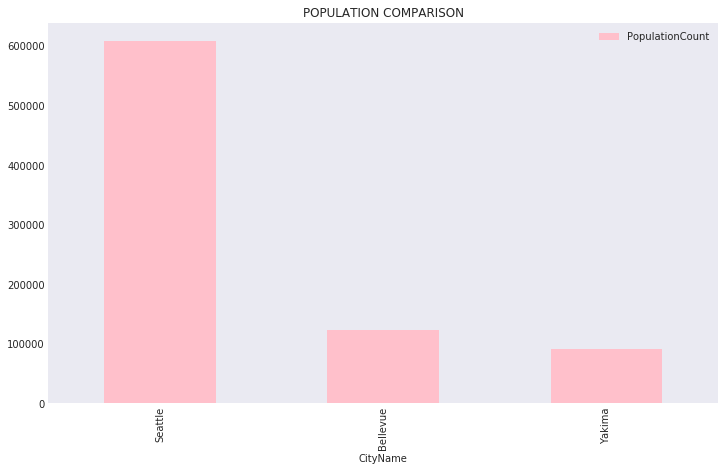

In [45]:
#fig4, ax4 = plt.subplots(ncols=1, figsize=(13,10))

#df = pd.DataFrame([[5.1, 3.5, 0], [4.9, 3.0, 0], [7.0, 3.2, 1],
#                [6.4, 3.2, 1], [5.9, 3.0, 2], [7.1, 4.5, 2]],
#                columns=['X', 'Y', 'value'])
data11.plot.bar(title = 'POPULATION COMPARISON', x ='CityName', y='PopulationCount', figsize=(12,7), color ='pink')


### Answer: There is no obvious correlation based on the population sizes for each city. For example, Spokane is densely populated despite being far away from large urban centers like Seattle and Bellevue.

# Is this a regional trend across the US?

In [46]:
resTX = spark.sql("select  Year,StateAbbr,StateDesc,CityName,GeographicLevel,Category, \
        Measure,Data_Value,PopulationCount,CategoryID,MeasureId,Short_Question_Text \
        from Viewone where Year = '2017'  and DataValueTypeID = 'CrdPrv' and StateAbbr='TX' ")

In [47]:
resTX.createOrReplaceTempView("TXview")

In [48]:
ressTX = spark.sql("select CityName,Category,\
                 Measure,Data_Value,PopulationCount \
                 from TXview where CityName in ('Pharr','Dallas')  and Category ='Health Outcomes' and \
                 Measure in ('Coronary heart disease among adults aged >=18 Years',\
                 'High blood pressure among adults aged >=18 Years',\
                'Stroke among adults aged >=18 Years') and GeographicLevel ='City' order by Measure")


In [49]:
ressTX.limit(100).toPandas()

,CityName,Category,Measure,Data_Value,PopulationCount
0,Pharr,Health Outcomes,Coronary heart disease among adults aged >=18 Years,6.700000,70400
1,Dallas,Health Outcomes,Coronary heart disease among adults aged >=18 Years,5.400000,1197816
2,Dallas,Health Outcomes,High blood pressure among adults aged >=18 Years,32.599998,1197816
3,Pharr,Health Outcomes,High blood pressure among adults aged >=18 Years,32.900002,70400
4,Dallas,Health Outcomes,Stroke among adults aged >=18 Years,3.200000,1197816
5,Pharr,Health Outcomes,Stroke among adults aged >=18 Years,3.400000,70400


### Answer: The trend is not the same across the US. As we see in the example above from Texas, the large urban area such as Dallas is overall unhealthier than the smaller area of Austin. This shows that the governments emphasize different priorities within each state. So states like Texas should try to create more health awareness in larger areas such as Dallas.